In [ ]:
#@title installing requirment
!pip install gnewsclient python-Levenshtein
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.4/169.4 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 51.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6048 sha256=cb91157780826a5a5f9d3af6e3b45657b559770cd5d522ebb7bd50fa97b85c66
  Stored in directory: /root/.cache/pip/wheels/f0/69/93/a47e9d621be168e9e33c7ce60524393c0b92ae83cf6c6e89c5
Successfully built sgmllib3k


In [ ]:
#@title importing required libraries
import transformers
import torch
import os
import pandas as pd

from torch import nn
from transformers import BertModel, BertTokenizer
from gnewsclient import gnewsclient
from datetime import datetime as dtime

# Fetch the input data for inference

In [ ]:
#@title Get market news and parse it

def get_national_news():
  client = gnewsclient.NewsClient(language='en', location='india', topic='Business', max_results=100)
  news = client.get_news() # list containes dict
  national_news = list()
  for title in news:
    national_news.append(title['title']+'. ')
  return national_news

# Get market news and parse it
def get_world_news():
  client = gnewsclient.NewsClient(language='en', location='india', topic='World', max_results=100)
  news = client.get_news() # list containes dict
  national_news = list()
  for title in news:
    national_news.append(title['title']+'. ')
  return national_news

news = get_national_news()
print("No of news: ", len(news), ", News: At Index[0] ", news[0], ", At Index[", len(news), "] ", news[len(news)-1])

No of news:  70 , News: At Index[0]  Will safeguard interests of shareholders, say Raymond's independent directors | Mint - Mint.  , At Index[ 70 ]  Sensex Jumps 493 pts, Nifty Ends At Record High Of 20,268; Broader Markets Hit New Peaks - News18. 


In [ ]:
#@title collect news from gnewsapi
def get_news():
    w_news = get_world_news()
    news = get_national_news()
    for t in w_news:
        news.append(t)
    return news
len(get_news())

140

In [ ]:
#@title saving news to file
current_time = dtime.now().strftime("%Y-%m-%d")
NEWS_PATH = r'/content/drive/MyDrive/PREDICTION/news/'+current_time+'.csv'
with open(NEWS_PATH, 'w') as f:
    for news in get_news():
        f.writelines(news+'\n')

In [ ]:
sentiment = list()
news_t = list()

with open(NEWS_PATH, 'r') as f:
    for news in f:
        print(news)
        news_t.append(news)
        sentiment.append(input('Enter Imapact on market [-1, 0, 1]: '))

Will safeguard interests of shareholders, say Raymond's independent directors | Mint - Mint. 



KeyboardInterrupt: ignored

In [ ]:
import pandas as pd
df = pd.DataFrame()

df['NEWS_TEXT'] = news_t
df['SENTIMENT'] = sentiment
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   NEWS_TEXT  3 non-null      int64
 1   SENTIMENT  3 non-null      int64
dtypes: int64(2)
memory usage: 176.0 bytes


In [ ]:
df.to_csv(NEWS_PATH)

# Inference Sentiment

In [ ]:
#@title Adding sentiment data to index day wise
MAX_LEN = 512
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
class_names = ['NEGETIVE', 'POSITIVE']
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(output[1])
    return self.out(output)

model = SentimentClassifier(2)
MODEL_PATH = '/content/drive/MyDrive/trained_model/bert_base_news_sentiment_v1.pth'
model.load_state_dict(torch.load(MODEL_PATH))
model = model.to(device)

def get_sentiment(text):
    '''
    Predicts sentiment of a text

    params: text:str Input text

    class: class_names = ['NEGETIVE', 'POSITIVE']

    return: predicted sentiment
    '''
    encoding = tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=MAX_LEN,
      return_token_type_ids=False,
      padding='max_length',
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    with torch.no_grad():
        output = model(input_ids, attention_mask)
    _, prediction = torch.max(output, dim=1)
    # print(f'Review text: {text}', f'Sentiment  : {class_names[prediction]}')
    return class_names[prediction]


cuda:0


In [ ]:
#@title Fetching news
def seek_date_to(given_date:str, delta_day):
    ymd = dtime.datetime.strptime(given_date, '%Y-%m-%d')
    date = dtime.datetime(ymd.year, ymd.month, ymd.day)
    skip_day = delta_day-(2*delta_day)
    '''
    if date.weekday() == 4:
        skip_day += 2
    elif date.weekday() == 5:
        skip_day += 1
    '''
    date += dtime.timedelta(days=skip_day)
    date = date.strftime('%Y-%m-%d')
    return date

NEWS_LOC = r'/content/drive/MyDrive/PREDICTION/news/
files = os.listdir(NEWS_LOC)

def get_news_data(date, files, news_loc):
    news = []
    if date+'.txt' in files:
        news_loc += date+'.txt'
        with open(news_loc, 'r') as f:
            for t in f:
                news.append(t)
        return news
    else:
        return news

In [ ]:
nifty_df = pd.read_csv(r'/content/drive/MyDrive/dataset/nifty50_sentiment_dataset.csv', index_col='Date')
nifty_df.drop(nifty_df.columns[0], axis=1, inplace=True)

In [ ]:
#@title Adding day wise news sentiment feature to NIFTY INDEX HISTORY

good_news = []
bad_news = []
# news_li = if_null_add_dummy([])
for date in nifty_df.Date:
    news = get_news_data(date, files, NEWS_LOC)
    if len(news) == 0:
        good_news.append(0)
        bad_news.append(0)
    else:
        good_counter = 0
        bad_counter = 0
        for title in news:
            if get_sentiment(title) == 'NEGETIVE':
                bad_counter += 1
            else:
                good_counter += 1
        good_news.append(good_counter)
        bad_news.append(bad_counter)

nifty_df.insert(len(nifty_df.columns), 'GOOD_NEWS', good_news)
nifty_df.insert(len(nifty_df.columns), 'BAD_NEWS', bad_news)

In [ ]:
#@title Removing Nan fields
nifty_df = nifty_df[~nifty_df['Open'].isnull()]
X, y = nifty_df.drop(columns=['Close']), nifty_df.Close.values
X.shape, y.shape

((3947, 6), (3947,))

In [ ]:
nifty_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 3947 entries, 2007-09-17 to 2023-10-23
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3947 non-null   float64
 1   High       3947 non-null   float64
 2   Low        3947 non-null   float64
 3   Close      3947 non-null   float64
 4   Volume     3947 non-null   float64
 5   GOOD_NEWS  3947 non-null   int64  
 6   BAD_NEWS   3947 non-null   int64  
dtypes: float64(5), int64(2)
memory usage: 246.7+ KB


In [ ]:
#@title Feature transformation
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()

X_trans = ss.fit_transform(X)
y_trans = mm.fit_transform(y.reshape(-1, 1))
'''
X_trans = torch.tensor(X_trans)
y_trans = torch.tensor(y_trans)
'''

'\nX_trans = torch.tensor(X_trans)\ny_trans = torch.tensor(y_trans)\n'

In [ ]:
import numpy as np

# split a multivariate sequence past, future samples (X and y)
def split_sequences(input_sequences, output_sequence, n_steps_in, n_steps_out):
    X, y = list(), list() # instantiate X and y
    for i in range(len(input_sequences)):
        # find the end of the input, output sequence
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        # check if we are beyond the dataset
        if out_end_ix > len(input_sequences): break
        # gather input and output of the pattern
        seq_x, seq_y = input_sequences[i:end_ix], output_sequence[end_ix-1:out_end_ix, -1]
        X.append(seq_x), y.append(seq_y)
    return np.array(X), np.array(y)

X_ss, y_mm = split_sequences(X_trans, y_trans, 90, 5)
print(X_ss.shape, y_mm.shape)

(3854, 90, 6) (3854, 5)


In [ ]:
# converting to tensors
df_X_ss = torch.Tensor(X_ss)
df_y_mm = torch.Tensor(y_mm)

TypeError: ignored

In [ ]:
# reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 90, df_X_ss.shape[2]))

In [ ]:
#@title torch Dataset
from torch.utils.data import Dataset, DataLoader

class NIFTY50Dataset(Dataset):

  def __init__(self, X, Y):
    self.x = X
    self.y = Y

  def __len__(self):
    return len(self.x)

  def __getitem__(self, idx):
    x = self.x[idx]
    y = self.y[idx]

    return x, y

In [ ]:
#@title Dataloader helper
def create_data_loader(x, y, batch_size):
  ds = NIFTY50Dataset(X=x, Y=y)

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2,
  )

In [ ]:
#@title Creating Dataloader
BATCH_SIZE = 1
train_dataloader = create_data_loader(df_X_ss, df_y_mm, BATCH_SIZE)

# Predict NIFTY50 for 1 week to future

In [ ]:

from torch import nn
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()

        self.hidden_size = hidden_size
        # [16, 90, 1024]
        self.vw = nn.Linear(self.hidden_size, self.hidden_size, dtype=torch.float64)
        self.kw = nn.Linear(self.hidden_size, self.hidden_size, dtype=torch.float64)
        self.qw = nn.Linear(self.hidden_size, self.hidden_size, dtype=torch.float64)

        self.gelu = nn.GELU(approximate='tanh')

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):

        # apply attention layer
        xvw = self.vw(x)
        xvw = self.gelu(xvw)

        xkw = self.kw(x)
        xkw = self.gelu(xkw)

        xqw = self.qw(x)
        xqw = self.gelu(xqw)

        xkqw = torch.mul(xkw, xqw)
        xkqw = self.softmax(torch.div(xkqw, torch.sqrt(torch.tensor(100))))

        # apply attention weights
        context = torch.mul(xvw, xkqw)

        return context

In [ ]:

#@title Model defination

# https://towardsdatascience.com/attention-seq2seq-with-pytorch-learning-to-invert-a-sequence-34faf4133e53

class BiLSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_classes = num_classes # output size
        self.input_size = input_size # input size
        self.hidden_size = hidden_size # neurons in each lstm layer
        self.num_layers = num_layers # num of layers
        self.seq_len = seq_len

        self.flat = nn.Flatten(start_dim=1) # preserve batch

        self.atten1 = Attention(self.hidden_size*2)
        self.atten2 = Attention(self.hidden_size*2)
        self.atten3 = Attention(self.hidden_size*2)
        self.atten4 = Attention(self.hidden_size*2)
        # LSTM model
        self.lstm1 = nn.LSTM(input_size=self.input_size,
                            hidden_size=self.hidden_size,
                            num_layers=self.num_layers,
                            batch_first=True,
                            dropout=0.2, bidirectional=True,
                            dtype=torch.float64,
                            ) # lstm

        self.lstm2 = nn.LSTM(input_size=self.hidden_size*2,
                            hidden_size=self.hidden_size,
                            num_layers=self.num_layers,
                            batch_first=True,
                            dropout=0.2, bidirectional=True,
                            dtype=torch.float64,
                            ) # lstm

        self.lstm3 = nn.LSTM(input_size=self.hidden_size*2,
                            hidden_size=self.hidden_size,
                            num_layers=self.num_layers,
                            batch_first=True,
                            dropout=0.2, bidirectional=True,
                            dtype=torch.float64,
                            ) # lstm

        self.lstm4 = nn.LSTM(input_size=self.hidden_size*2,
                            hidden_size=self.hidden_size,
                            num_layers=self.num_layers,
                            batch_first=True,
                            dropout=0.2, bidirectional=True,
                            dtype=torch.float64,
                            ) # lstm

        self.fc1 = nn.Sequential(
            nn.ReLU(),
            nn.Linear(self.hidden_size*seq_len*2, 1024, dtype=torch.float64), # linear layer 1
            nn.LayerNorm(1024, dtype=torch.float64),
            nn.ReLU(),

            nn.Linear(1024, 512, dtype=torch.float64), # linear layer 2
            nn.LayerNorm(512, dtype=torch.float64),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.ReLU(),
            nn.Linear(512, 128, dtype=torch.float64), # linear layer 1
            nn.LayerNorm(128, dtype=torch.float64),
            nn.ReLU(),

            nn.Linear(128, num_classes, dtype=torch.float64), # linear layer 2
            nn.LayerNorm(num_classes, dtype=torch.float64),
            nn.ReLU()
        )

    def forward(self, x):
       # propagate input through LSTM
        x, (hn, cn) = self.lstm1(x) # (input, hidden, and internal state)
        x = self.atten1(x)

        x, (hn, cn) = self.lstm2(x) # (input, hidden, and internal state)
        x = self.atten2(x)

        x, (hn, cn) = self.lstm3(x) # (input, hidden, and internal state)
        x = self.atten3(x)

        x, (hn, cn) = self.lstm4(x) # (input, hidden, and internal state)
        x = self.atten4(x)

        x = self.flat(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [ ]:
#@title Initializing model
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using: ',device)

seq_len = 90
input_size = 6 # number of features
hidden_size = 256 # number of features in hidden state
num_layers = 8 # number of stacked lstm layers

num_classes = 5 # number of output classes
# num_classes, input_size, hidden_size, num_lstm_atten_head = 4
model = BiLSTM(num_classes, input_size, hidden_size, num_layers)
MODEL_PATH = r'/content/drive/MyDrive/training_model/nifty50_weekly_pred_v3_0.pth'
model.load_state_dict(torch.load(MODEL_PATH))
model = model.to(device)
'''
t_in = next(iter(train_dataloader))
#t_in = torch.rand(16, 90, 6)
#print(t_in.dtype)
out = model(t_in[0].to(device))
print(out.shape)
'''

Using:  cuda:0


'\nt_in = next(iter(train_dataloader))\n#t_in = torch.rand(16, 90, 6)\n#print(t_in.dtype)\nout = model(t_in[0].to(device))\nprint(out.shape)\n'

In [ ]:
t_in = next(iter(train_dataloader))
#t_in = torch.rand(16, 90, 6, dtype=torch.float64)
print(t_in[0].dtype)
out = model(torch.DoubleTensor(t_in[0]).to(device))
print(out.shape)

torch.float32


TypeError: ignored

In [ ]:
#@title Test function
def test_loop(dataloader, model, device):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()

    pred_l = []
    label = []
    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True

    with torch.no_grad():
        for X, y in dataloader:

            # sending to gpu
            X = X.to(device)
            y = y.to(device)

            pred = model(X)
            for v in pred:
                pred_l.append(v)

            for v in y:
                label.append(v)

    return pred_l, label


In [ ]:
pred, label = test_loop(train_dataloader, model, device)

RuntimeError: ignored

# Coninues Learning and Optimization

In [ ]:
#@title Hyperparameters
import torch.optim.lr_scheduler as lr_scheduler
EPOCHS = 25
total_steps = len(train_dataloader) * EPOCHS

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
#scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.3, total_iters=10)
loss_fn = nn.MSELoss().to(device)

In [ ]:
#@title Re-Train news model

In [ ]:
#@title Re-Train prediction model

In [ ]:
#@title Ploting the losses
hist_path = [r'/content/drive/MyDrive/training_hist/nifty50_weekly_pred_v3_run1.pkl',
    r'/content/drive/MyDrive/training_hist/nifty50_weekly_pred_v3_run2.pkl',
    r'/content/drive/MyDrive/training_hist/nifty50_weekly_pred_v3_run3.pkl']

#history['train_loss'].append(train_loss)
#history['val_loss'].append(val_loss)

import pickle

# Open the file in read-binary mode
with open(hist_path[0], "rb") as f:

    # Load the data from the file
    data = pickle.load(f)
# Open the file in read-binary mode
with open(hist_path[1], "rb") as f:

    # Load the data from the file
    data1 = pickle.load(f)

    # Open the file in read-binary mode
with open(hist_path[2], "rb") as f:

    # Load the data from the file
    data2 = pickle.load(f)

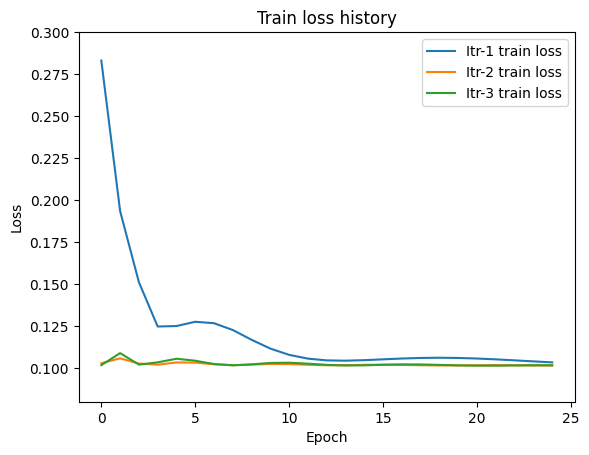

In [ ]:
import matplotlib.pyplot as plt

plt.plot(data['train_loss'], label='Itr-1 train loss')
plt.plot(data1['train_loss'], label='Itr-2 train loss')
plt.plot(data2['train_loss'], label='Itr-3 train loss')

plt.title('Train loss history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.08, 0.3]);

# Show the plot
plt.show()

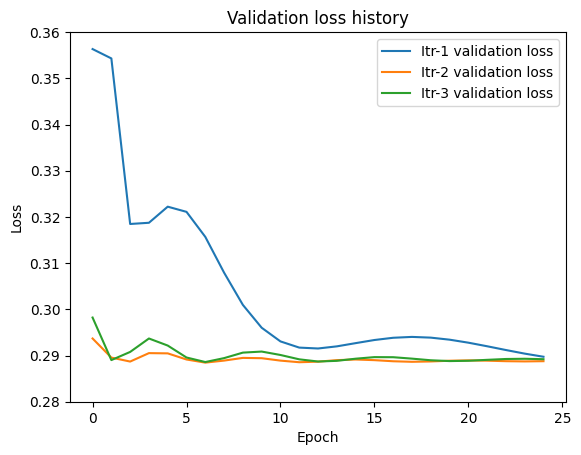

In [ ]:
plt.plot(data['val_loss'], label='Itr-1 validation loss')
plt.plot(data1['val_loss'], label='Itr-2 validation loss')
plt.plot(data2['val_loss'], label='Itr-3 validation loss')

plt.title('Validation loss history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.28, 0.36]);

# Show the plot
plt.show()